In [1]:
# Data Science
import numpy  as np
import pandas as pd
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Tricks
sns.set(style='ticks', context='talk', font_scale=1.15)
%matplotlib inline

In [2]:
import os, sys
import skimage.io

from PIL import Image

# Root directory of the project
ROOT_DIR = os.path.abspath(Mask_RCNN_ROOT)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import visualize

In [3]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

vip_class = ['person','skis','snowboard']

---

# Load data

In [4]:
clean_df = pd.read_pickle('./pkl/clean_df.pkl').rename(columns={'class':'Class'})
# data_df  = pd.read_pickle('./pkl/data_df.pkl')
# data_df['Class'] = [ class_names[int(i)] for i in data_df['class_ids'] ]

---

# Helper func.

In [5]:
def Show_Img(imgID, showBox=True, showMask=True, RAW=False, getArray=False):
    """
    Show image for given image ID.

    Parameters (Input)
    ----------
    imgID    : str
        The ID for image
    showBox  : bool
        Show the Boxes generated by Mask R-CNN
    showMask : bool
        Show the Masks generated by Mask R-CNN
    RAW      : bool
        Show the original boxes (otherwise show the passing filter boxes)
    getArray : bool
        Return Array, not show image, will overwrite
        showBox=False, showMask=False, RAW=True

    Returns
    -------
    None (Just show image)
    or
    Array of the image

    Require
    -------
    data_df : DataFrame
        Saved Mask R-CNN outputs

    from mrcnn import visualize
    """
    imgID  = str(imgID)
    if not os.path.exists('imgs_pw_20190331_wl_n1/'+imgID+'.jpg'):
        print ('Try to treat it as a file!')
        if not os.path.exists(imgID):
            print ('Not such image!')
            return
        else:
            image = skimage.io.imread(imgID)
    else:
        image  = skimage.io.imread('imgs_pw_20190331_wl_n1/'+imgID+'.jpg')

    if getArray:
        return np.array(image)

    if RAW:
        df = data_df
    else:
        df = clean_df

    img_df = df.query('imgID==@imgID').copy()

    if not img_df.shape[0]:
        print ('Not record in data_df!')
        image = skimage.io.imread('imgs_pw_20190331_wl_n1/'+imgID+'.jpg')
        visualize.display_instances(
            image, 
            np.zeros((2,2)), # Placeholder
            np.zeros((2,2)), # Placeholder
            np.zeros((2,2)), # Placeholder
            np.array(0),     # Placeholder
            np.array(0),     # Placeholder
            figsize=(8,8),
            show_mask=False,
            show_bbox=False,
        )
        return
    else:
        image = skimage.io.imread('imgs_pw_20190331_wl_n1/'+imgID+'.jpg')

        result = {}
        for it in ['rois','class_ids','scores','masks']:
            result[it] = np.array( img_df[it].to_list() )

        result['masks'] = np.rollaxis(
                result['masks'].reshape(-1, image.shape[0],image.shape[1] ), 0, 3
        )

        visualize.display_instances(
            image, 
            result['rois'], 
            result['masks'], 
            result['class_ids'].astype(int), 
            class_names, 
            result['scores'],
            figsize=(8,8),
            show_mask=showMask,
            show_bbox=showBox,
        )
        return 


In [6]:
def extInBoxPixels(record, getMask=False, showTag=False):
    """
    Extract InBox pixels from given Box and image ID.

    Parameters (Input)
    ----------
    record  : Series
        The record for a box
    getMask : bool
        Only extract the InMask pixels
    showTag : bool
        Show the extracted pixels

    Returns
    -------
    ext_Box : Array
    numpy array (Matrix) with InBox pixels
        Shape = (Unknown, Unknown, 3)
    """

    assert type(record) == type(pd.Series()), 'Input should be a Pandas Series.'
    image = skimage.io.imread('imgs_pw_20190331_wl_n1/'+record['imgID']+'.jpg')

    (x1, y1, x2, y2) = record['rois']

    if not getMask:
        ext_Box = image[x1:x2, y1:y2, :]
    else:
        # Mask Invert
        ext_Mask = np.invert( record['masks'] ).reshape( image.shape[0],image.shape[1] )
        # First, Make Inverted Mask as a white/snow background (255,255,255) 
        # Next,  Add image to the Inverted Mask
        # Then,  Clip the overflow (>255) pixels (make them white)
        ext_Img = (
            255*np.stack( [ext_Mask]*3, axis=2 )
            +image
        ).clip(max=255)
        # Finally, Crop the box
        ext_Box  = ext_Img[x1:x2, y1:y2, :]

    return ext_Box


In [7]:
def squareBox (BoxArray):
    """
    Reshape a Unknow shape Box with pixels to a square Box with 150x150.

    Parameters (Input)
    ----------
    BoxArray : numpy array (Matrix)
        Array with InBox pixels

    Returns
    -------
    BoxArraySquared : Array
    numpy array (Matrix) with InBox pixels
        Shape = (150, 150, 3)
        
    Require
    -------
    from PIL import Image
    """
    BoxArraySquared = np.array(
        resize_tool( 
            Image.fromarray(BoxArray.astype('uint8')),
            width  = 150,
            height = 150,
        )
    )
    return BoxArraySquared

################################################################################
def resize_tool(image_pil, width, height):
    '''
    Resize PIL image keeping ratio and using white background.
    
    From https://stackoverflow.com/questions/44370469/python-image-resizing-keep-proportion-add-white-background
    '''
    ratio_w = width  / image_pil.width
    ratio_h = height / image_pil.height
    if ratio_w < ratio_h:
        # It must be fixed by width
        resize_width = width
        resize_height = round(ratio_w * image_pil.height)
    else:
        # Fixed by height
        resize_width = round(ratio_h * image_pil.width)
        resize_height = height
    image_resize = image_pil.resize((resize_width, resize_height), Image.ANTIALIAS)

    background = Image.new('RGB', (width, height), (255, 255, 255))
    offset = (round((width - resize_width) / 2), round((height - resize_height) / 2))

    background.paste(image_resize, offset)
    
    return background

---

# ResNet

In [8]:
# from keras.applications.vgg19    import preprocess_input, VGG19
# from keras.applications.resnet50 import preprocess_input, ResNet50
from keras.applications.densenet import preprocess_input, DenseNet201

# model = VGG19(
# model = ResNet50(
model = DenseNet201(
    weights = 'imagenet', 
    pooling = 'max',
    input_shape = (150,150,3),
    include_top = False
)

Using TensorFlow backend.


In [9]:
hs = []
ws = []

def mapper(row):
    ext_Box = extInBoxPixels(row, getMask=False)
    h,w = ext_Box.shape[:2]
    hs.append(h)
    ws.append(w)
    sqr_Box = squareBox(ext_Box)
    rn50_in = preprocess_input(sqr_Box)
    return rn50_in

In [10]:
rn50_in = clean_df.query('Class=="person"').apply(mapper, axis=1)
rn50_in = np.stack(rn50_in)

In [11]:
v = model.predict(rn50_in)
v_norm = v/np.linalg.norm(v,axis=0)

# np.save('VGG19_clean_person_box',v)
# np.save('ResNet50_clean_person_box',v)
np.save('DenseNet201_clean_person_box',v)

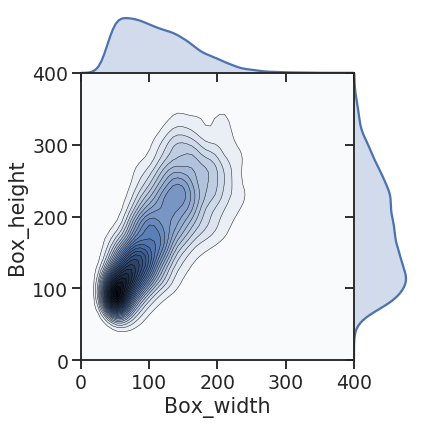

In [12]:
x = pd.Series(ws, name="Box_width")
y = pd.Series(hs, name="Box_height")
g = (
    sns.jointplot(x, y, kind="kde", height=6, space=0, n_levels=25, xlim=(0,400), ylim=(0,400), gridsize=80)
    .plot_joint(sns.kdeplot, shade=False, n_levels=25, color='black', linewidths=0.5, gridsize=80)
).savefig('BoxSize.png')

In [13]:
from sklearn.decomposition import PCA
# from sklearn.manifold      import TSNE
from MulticoreTSNE         import MulticoreTSNE as TSNE
from umap                  import UMAP 
from hdbscan               import HDBSCAN

pca_model  = PCA(  n_components=2, random_state=0 )
tsne_model = TSNE( n_components=2, random_state=0, n_jobs=4 )
umap_model = UMAP( n_components=2, random_state=0 )

pca_df  = pd.DataFrame( pca_model.fit_transform( v) ).rename(columns={0:'PCA1',  1:'PCA2'} )
tsne_df = pd.DataFrame( tsne_model.fit_transform(v) ).rename(columns={0:'tSNE1', 1:'tSNE2'})
umap_df = pd.DataFrame( umap_model.fit_transform(v) ).rename(columns={0:'UMAP1', 1:'UMAP2'})

hdbscan_labels = HDBSCAN(min_cluster_size=5).fit_predict(tsne_df)
clustered = hdbscan_labels>0

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


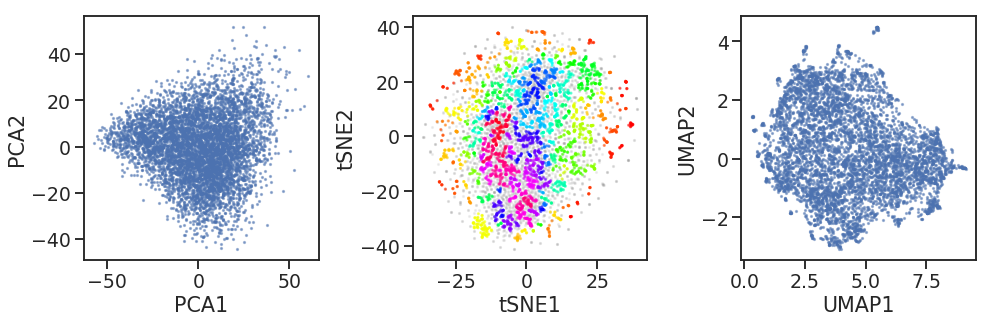

In [14]:
fig, ax = plt.subplots(ncols=3,figsize=(16,5))

pca_df.plot.scatter( x='PCA1', y='PCA2',  s=3, alpha=0.5, ax=ax[0])

tsne_df.iloc[~clustered].plot.scatter(
                     x='tSNE1',y='tSNE2', s=3, alpha=0.1, ax=ax[1],
                     colorbar=False, color='gray', 
)
tsne_df.iloc[clustered].plot.scatter(
                     x='tSNE1',y='tSNE2', s=3, alpha=0.5, ax=ax[1],
                     colorbar=False, colormap='hsv',
                     c=hdbscan_labels[clustered], 
)

umap_df.plot.scatter(x='UMAP1',y='UMAP2', s=3, alpha=0.5, ax=ax[2])

fig.subplots_adjust(wspace=0.4, bottom=0.2)

fig.savefig('DR.png')

---

In [15]:
# sim = clean_df.query('Class=="person"').reset_index().drop('index',axis=1).loc[umap_df.query('UMAP1>5 & UMAP2>4').index]

In [16]:
# sim.shape

In [17]:
# fig,ax = plt.subplots( nrows=int(np.sqrt(sim.shape[0])), ncols=int(np.sqrt(sim.shape[0])), figsize=(8,8))
# axs = ax.flatten()
# for n,row in enumerate(sim.iterrows()):
#     axs[n].imshow( squareBox(extInBoxPixels(row[1])) )
#     axs[n].axis('off')
#     if n == len(axs)-1:
#         break

# fig,ax = plt.subplots( nrows=int(np.sqrt(sim.shape[0])), ncols=int(np.sqrt(sim.shape[0])), figsize=(16,16))
# axs = ax.flatten()
# for n,ID in enumerate(sim['imgID'].values):
#     img = Show_Img(ID,getArray=True)
#     axs[n].imshow( img )
#     axs[n].axis('off')
#     if n == len(axs)-1:
#         break

In [18]:
# gb = pd.concat(
#     [
#         tsne_df,
#         pd.Series(hdbscan_labels,name='label')
#     ], axis=1
# ).query('label>0 & label<9').reset_index().groupby('label')

# for g,df in gb:
#     sim = clean_df.query('Class=="person"').reset_index().drop('index',axis=1).loc[df['index'].values]
    
#     fig,ax = plt.subplots( nrows=int(np.sqrt(sim.shape[0])), ncols=int(np.sqrt(sim.shape[0])), figsize=(8,8))
#     axs = ax.flatten()
#     for n,row in enumerate(sim.iterrows()):
#         axs[n].imshow( squareBox(extInBoxPixels(row[1])) )
#         axs[n].axis('off')
#         if n == len(axs)-1:
#             break
#     plt.show()


---